# Discrete Diffusion (Predicting the name of the dish from its image)

In [1]:
import json
import random
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import clip
from sklearn.model_selection import train_test_split
import requests
import tarfile
import matplotlib.pyplot as plt

# Download and extract Food-101 dataset
url = 'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz'
response = requests.get(url, stream=True)
with open('food-101.tar.gz', 'wb') as file:
    file.write(response.raw.read())

with tarfile.open('food-101.tar.gz') as tar:
    tar.extractall()

# Initialize CLIP model 
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

class Food101Dataset(Dataset):
    def __init__(self, image_paths, labels, clip_model, preprocess, device):
        self.image_paths = image_paths
        self.labels = labels
        self.clip_model = clip_model
        self.preprocess = preprocess
        self.device = device
        self.categories = sorted(set(labels))
        self.category_to_idx = {cat: idx for idx, cat in enumerate(self.categories)}
        self.idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}
        self.data = self._prepare_data()

    def _prepare_data(self):
        data = []
        for image_path, label in zip(self.image_paths, self.labels):
            image = self.preprocess(Image.open(image_path)).unsqueeze(0).to(self.device)
            with torch.no_grad():
                image_features = self.clip_model.encode_image(image).cpu().numpy()

            # Convert image_features to float
            image_features = torch.tensor(image_features, dtype=torch.float32)  # Ensure float32 if not already

            category_idx = self.category_to_idx[label]

            data.append((image_features, category_idx))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Load image paths and labels
image_paths = []
labels = []
with open('food-101/meta/train.txt') as f:
    for line in f:
        line = line.strip()
        image_path = os.path.join('food-101/images', line + '.jpg')
        category = line.split('/')[0]
        image_paths.append(image_path)
        labels.append(category)



/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Shuffle and select 20000 samples
sample_size = 20000
indices = list(range(len(image_paths)))
# random.seed(42)  # Set seed for reproducibility
# random.shuffle(indices)
selected_indices = indices[:sample_size]

# Create new lists for the selected samples
image_paths = [image_paths[i] for i in selected_indices]
labels = [labels[i] for i in selected_indices]


# Split into train and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = Food101Dataset(train_paths, train_labels, clip_model, preprocess, device)
test_dataset = Food101Dataset(test_paths, test_labels, clip_model, preprocess, device)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


In [3]:
  class DiffusionProcess:
    def __init__(self, num_categories, num_timesteps, beta_start, beta_end, use_gaussian=False):
        self.num_categories = num_categories
        self.num_timesteps = num_timesteps
        self.betas = np.linspace(beta_start, beta_end, num_timesteps)
        self.use_gaussian = use_gaussian # default is uniform
        self.transition_matrices = self._create_transition_matrices()
        self.cumulative_matrices = self._create_cumulative_matrices()

    def _create_transition_matrices(self):
        matrices = []
        for beta in self.betas:
            if self.use_gaussian:
                matrices.append(self._create_gaussian_matrix(beta))
            else:
                mat = np.full((self.num_categories, self.num_categories), beta / self.num_categories)
                np.fill_diagonal(mat, 1 - beta * (self.num_categories - 1) / self.num_categories)
                matrices.append(mat)
        return np.array(matrices)

    def _create_cumulative_matrices(self):
        cumulative_matrices = []
        cumulative_product = np.eye(self.num_categories)  # Start with identity matrix
        for t in range(self.num_timesteps):
            cumulative_product = np.dot(cumulative_product, self.transition_matrices[t])
            cumulative_matrices.append(cumulative_product.copy())
        return np.array(cumulative_matrices)

    def forward_diffusion(self, x, t):
        cumulative_transition_mat = self.cumulative_matrices[t]
        noisy_seq = x.copy()
        for i in range(len(noisy_seq)):
            noisy_seq[i] = np.random.choice(self.num_categories, p=cumulative_transition_mat[noisy_seq[i]])
        return noisy_seq


# Initialize diffusion process
num_timesteps = 20
beta_start = 0.01
beta_end = 0.1
num_categories = len(train_dataset.categories)
diffusion = DiffusionProcess(num_categories, num_timesteps, beta_start, beta_end)


In [4]:
class DenoisingModel(nn.Module):
    def __init__(self, num_timesteps, clip_embedding_dim, num_categories):
        super(DenoisingModel, self).__init__()
        self.clip_embedding_dim = clip_embedding_dim
        self.num_timesteps = num_timesteps
        self.num_categories = num_categories
        
        self.embedding = nn.Embedding(num_categories, clip_embedding_dim)
        self.fc_out = nn.Linear(2*clip_embedding_dim, num_categories)
        
    def forward(self, noisy_data, image_features):
        
        # Iterative denoising steps
        for _ in range(self.num_timesteps):
            # Embedding for the current timestep t
            noisy_data_t = self.embedding(noisy_data)  # Shape: (batch_size, clip_embedding_dim)
            
            # Concatenate image features and current denoised token
            context = torch.cat([image_features, noisy_data_t], dim=-1)
            
            # Apply fully connected layer
            hidden = torch.relu(self.fc_out(context))
            
            # Apply softmax to get probabilities for current timestep
            probabilities = torch.softmax(hidden, dim=-1)  # Shape: (batch_size, num_categories)
            
            # Reconstruct noisy_data for current timestep using argmax
            _, noisy_data = torch.max(probabilities, dim=-1)  # Shape: (batch_size,)
            
        return probabilities
    
    def forward_visu(self, noisy_data, image_features):
        
        categories = [noisy_data]
        # Iterative denoising steps
        for _ in range(self.num_timesteps):
            # Embedding for the current timestep t
            noisy_data_t = self.embedding(noisy_data)  # Shape: (batch_size, clip_embedding_dim)
            
            # Concatenate image features and current denoised token
            context = torch.cat([image_features, noisy_data_t], dim=-1)
            
            # Apply fully connected layer
            hidden = torch.relu(self.fc_out(context))
            
            # Apply softmax to get probabilities for current timestep
            probabilities = torch.softmax(hidden, dim=-1)  # Shape: (batch_size, num_categories)
            
            # Reconstruct noisy_data for current timestep using argmax
            _, noisy_data = torch.max(probabilities, dim=-1)  # Shape: (batch_size,)
            
            categories.append(noisy_data)
            
        return categories




# Initialize model, loss function, and optimizer
clip_embedding_dim = clip_model.encode_image(preprocess(Image.open(train_paths[0])).unsqueeze(0).to(device)).shape[-1]
model = DenoisingModel(num_categories, clip_embedding_dim, num_categories).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training loop
num_epochs = 1000
batch_size = 512

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for batch_idx, (image_features, category_idxs) in enumerate(train_loader):
        image_features = image_features.to(device)
        category_idxs = category_idxs.to(device)
        
        # Forward diffusion
        noisy_data = diffusion.forward_diffusion(category_idxs.cpu().numpy(), epoch % num_timesteps)
        noisy_data = torch.tensor(noisy_data, dtype=torch.long).to(device)
        
        optimizer.zero_grad()
        
        # Ensure image_features has shape (batch_size, clip_embedding_dim)
        image_features = image_features.squeeze(1)
        
        # Model forward pass
        outputs = model(noisy_data, image_features)
        
        # Calculate the loss
        # Reshape outputs to (batch_size, num_categories)
        loss = criterion(outputs, category_idxs)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Print epoch loss
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}')


In [6]:

def evaluate(model, criterion, data_loader, device, num_timesteps):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for image_features, category_idxs in data_loader:
            image_features = image_features.to(device)
            image_features = image_features.squeeze(1)

            category_idxs = category_idxs.to(device)
            
            batch_size = image_features.size(0)
            
            # Initialize noisy_data randomly for evaluation
            noisy_data = torch.randint(0, model.num_categories, (batch_size,), dtype=torch.long).to(device)
            
            # Model forward pass to denoise noisy_data
            outputs = model(noisy_data, image_features)
            
            # Calculate the loss
            loss = criterion(outputs, category_idxs)
            total_loss += loss.item() * batch_size
            
            # Update noisy_data with predicted categories
            noisy_data = torch.argmax(outputs, dim=1)
            
            # Calculate accuracy
            total_correct += (noisy_data == category_idxs).sum().item()
            total_samples += batch_size
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    
    return avg_loss, accuracy


# Assuming you have initialized model, criterion, data_loader, device, diffusion, and num_timesteps appropriately

avg_loss, accuracy = evaluate(model, criterion, train_loader, device, num_timesteps)
print(f'Evaluation Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}')
avg_loss, accuracy = evaluate(model, criterion, test_loader, device, num_timesteps)
print(f'Evaluation Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')



Evaluation Loss: 2.5625, Train Accuracy: 0.7873
Evaluation Loss: 2.5806, Test Accuracy: 0.7700


In [7]:

def visualize_predictions(model, image_paths, true_categories, preprocess, clip_model, device, classes_file='food-101/meta/classes.txt'):
    # Load class names
    with open(classes_file, 'r') as f:
        class_names = [line.strip() for line in f.readlines()]
    
    model.eval()
    plt.figure(figsize=(12, 48))
    
    for i, (img_path, true_cat) in enumerate(zip(image_paths, true_categories), 1):
        img = Image.open(img_path)
        image_tensor = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = clip_model.encode_image(image_tensor)
            noisy_data = torch.randint(0, model.num_categories, (1,), dtype=torch.long).to(device)
            outputs = model(noisy_data, image_features)
            predicted_idx = torch.argmax(outputs).item()
            predicted_cat = class_names[predicted_idx]
        
        plt.subplot(num_categories, 3, i)
        plt.imshow(img)
        plt.title(f'Ground Truth: {true_cat}\nPredicted: {predicted_cat}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def select_random_images(root_dir, categories, num_images_per_category=1):
    selected_images = []
    for category in categories:
        category_path = os.path.join(root_dir, category)
        images = os.listdir(category_path)
        random.shuffle(images)
        selected_images.extend([os.path.join(category_path, img) for img in images[:num_images_per_category]])
    return selected_images


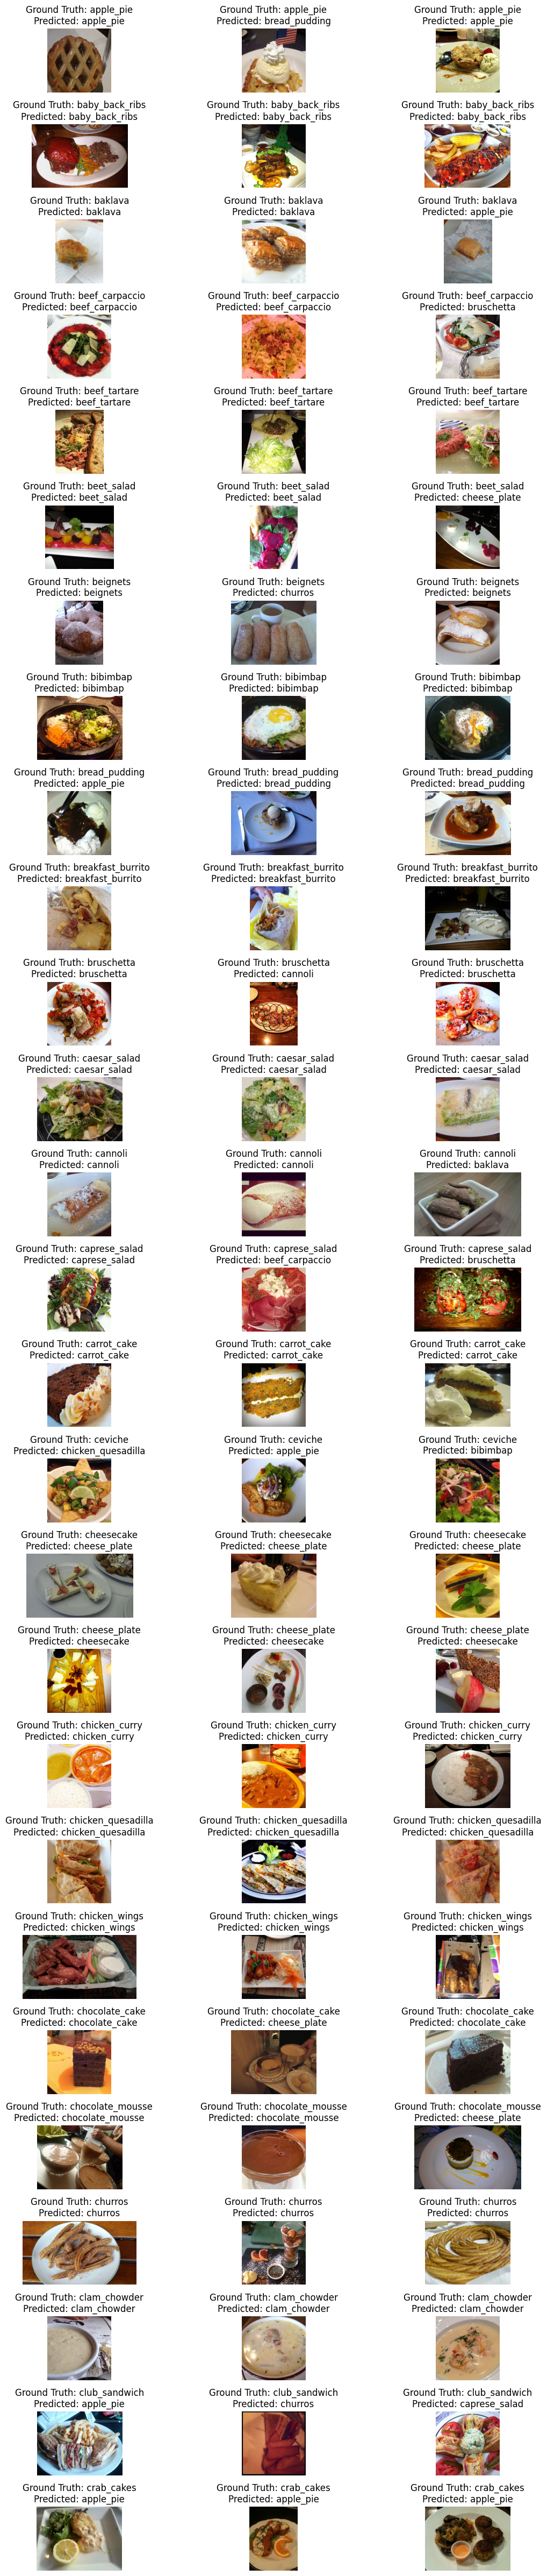

In [8]:
# Assuming you have initialized model, preprocess, clip_model, and device appropriately
root_dir = 'food-101/images'
classes_file='food-101/meta/classes.txt'
with open(classes_file, 'r') as f:
    categories = [line.strip() for line in f.readlines()][:num_categories]
# categories = ['apple_pie', 'baby_back_ribs', 'baklava']
image_paths = select_random_images(root_dir, categories, num_images_per_category=3)
true_categories = [os.path.basename(os.path.dirname(img_path)) for img_path in image_paths]

# Assuming model is your trained DenoisingModel
model.eval()

# Visualize predictions
visualize_predictions(model, image_paths, true_categories, preprocess, clip_model, device)


In [30]:
import os
import tempfile

from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def visualize_prediction_animation(model, image_path, preprocess, clip_model, device, classes_file='food-101/meta/classes.txt'):
    # Load class names
    with open(classes_file, 'r') as f:
        class_names = [line.strip() for line in f.readlines()]

    img = Image.open(image_path)
    image_tensor = preprocess(img).unsqueeze(0).to(device)
    image_features = clip_model.encode_image(image_tensor)

    num_timesteps = model.num_timesteps  # Assuming model.num_timesteps is known

    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Generate noisy_data for the current timestep
    noisy_data = torch.randint(0, model.num_categories, (1,), dtype=torch.long).to(device)

    # Get predicted indices for all timesteps from T to 0
    forward_visu = model.forward_visu(noisy_data, image_features)
    forward_visu = forward_visu[::-1]

    def update(frame):
        ax.clear()
        ax.imshow(img)
        ax.axis('off')
        
        # Determine current timestep (time decreases from T to 0)
        current_timestep = num_timesteps - frame 

        # Get predicted category index for the current timestep
        predicted_idx = forward_visu[current_timestep]

        # Get predicted category name
        predicted_cat = class_names[predicted_idx]

        ax.set_title(f'Timestep: {current_timestep}\nPredicted: {predicted_cat}')

    anim = FuncAnimation(fig, update, frames=num_timesteps, interval=1000, repeat=True)
    
    # Save animation as a GIF
    temp_file = tempfile.NamedTemporaryFile(suffix='.gif', delete=False)
    anim.save(temp_file.name, writer='imagemagick')

    plt.close()  # To prevent displaying the static plot before animation

    # Return a download link for the GIF file
    gif_path = temp_file.name
    
    # Save the GIF locally with a desired filename
    with open("prediction_animation.gif", "wb") as f:
        with open(gif_path, "rb") as gif_file:
            f.write(gif_file.read())
            
    gif_link = f'<a href="{gif_path}" download>Download Animation (GIF)</a>'
    return HTML(gif_link)


In [31]:
# Assuming you have initialized model, preprocess, clip_model, and device appropriately
root_dir = 'food-101/images'
image_path = '/workspace/code/notebooks/food-101/images/breakfast_burrito/352460.jpg'  # Replace with actual path to the image
classes_file = 'food-101/meta/classes.txt'

# Example of using the function*
visualize_prediction_animation(model, image_path, preprocess, clip_model, device, classes_file)

MovieWriter imagemagick unavailable; using Pillow instead.
